In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import tensorflow_addons as tfa
from tensorflow.python.client import device_lib 

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  4


In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

In [4]:
tf.config.set_visible_devices(
    physical_devices[1], 'GPU'
)

# Data Loading

Pre-processing deta details:
* They did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each pixel.

Data augmentation:

* The first form of data augmentation consists of generating image translations and horizontal reflections.
* The second form of data augmentation consists of altering the intensities of the RGB channels in training images.

In [5]:
def show_img (img):
    plt.figure(figsize=(6,6))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img);
    plt.axis('off');

In [6]:
path_train = 'CINIC10/train/'
path_val = 'CINIC10/valid/'
path_test = 'CINIC10/test/'
data_dir_train = pathlib.Path(path_train)
data_dir_val = pathlib.Path(path_val)
data_dir_test = pathlib.Path(path_test)

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.png')))
image_count_val = len(list(data_dir_val.glob('*/*.png')))
image_count_test = len(list(data_dir_test.glob('*/*.png')))

In [8]:
image_count_train, image_count_val, image_count_test

(90000, 90000, 90000)

In [9]:
CLASS_NAMES = np.array([item.name for item in data_dir_train.glob('*')])
CLASS_NAMES

array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
       'horse', 'ship', 'truck'], dtype='<U10')

 ### Create a dataset of the file paths:

In [10]:
list_ds_train = tf.data.Dataset.list_files(str(data_dir_train/'*/*'))
list_ds_val = tf.data.Dataset.list_files(str(data_dir_val/'*/*'))
list_ds_test = tf.data.Dataset.list_files(str(data_dir_test/'*/*'))

In [11]:
paths_example = []
for f in list_ds_train.take(5):
    paths_example.append(f.numpy())
    print(f.numpy())    

b'CINIC10/train/cat/n02129923_3935.png'
b'CINIC10/train/dog/n02108089_11011.png'
b'CINIC10/train/airplane/cifar10-train-47326.png'
b'CINIC10/train/deer/n02439033_8126.png'
b'CINIC10/train/cat/n02123045_13011.png'


In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == CLASS_NAMES

Example of usage:

In [13]:
example_path = paths_example[0].decode()
label_arr = get_label(example_path)
label_of_this_path = CLASS_NAMES[np.where(label_arr==True)]
label_of_this_path

array(['cat'], dtype='<U10')

Check if is is correct labelled:

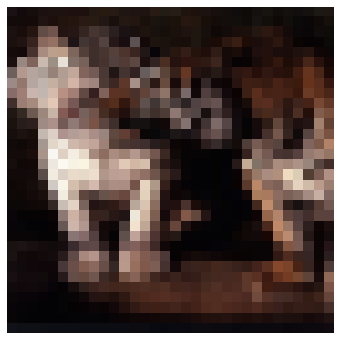

In [14]:
image = cv2.imread(example_path)
show_img(image)

# Helper Functions

In [15]:
def decode_img(img, dsize):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [dsize[0], dsize[1]])

In [16]:
def process_path(file_path):
    size = (227,227)
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img,size)
    return img, label

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [18]:
labeled_ds_train = list_ds_train.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_valid = list_ds_val.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

Check the pair of entries:

In [19]:
for image, label in labeled_ds_train.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (227, 227, 3)
Label:  [False False False False False False False False  True False]


# Pre-processing data

In [20]:
def augmentation(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_brightness(x, max_delta=0.5)
    return x, y

In [21]:
def normalize(x, y):
    x = tf.image.per_image_standardization(x)
    return x, y

In [33]:
def prepare_for_training(ds, training = False,cache=True, shuffle_buffer_size=1000, batch_size = 128):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    if training:
        ds = ds.map(augmentation)
    ds = ds.map(normalize)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [34]:
train_ds = prepare_for_training(labeled_ds_train, training = True, batch_size = 64)
val_ds = prepare_for_training(labeled_ds_valid, batch_size = 64)
test_ds = prepare_for_training(labeled_ds_test, batch_size = 64)

In [24]:
image_batch, label_batch = next(iter(test_ds))

In [25]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n]);
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off');

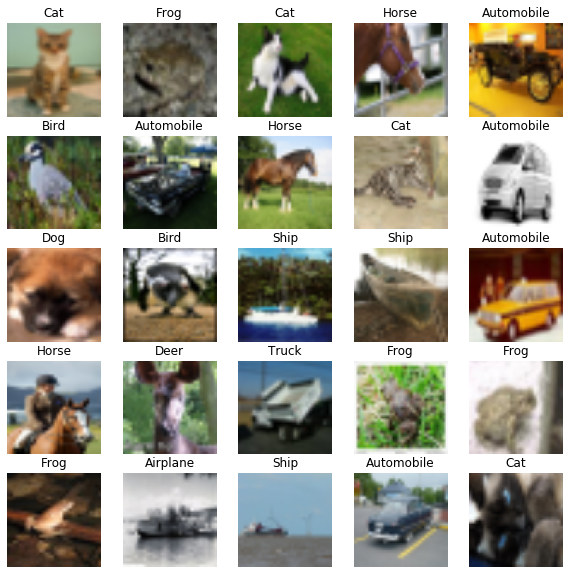

In [26]:
show_batch(image_batch.numpy(), label_batch.numpy())

# AlexNet learning details:

* optimizer = SGD 
* batch_size = 128
* momentum = 0.9 
* weight decay = 0.0005 
* weights initialization from a zero-mean Gaussian distribution (sd = 0.01)
* divide the learning rate by ten, when the validation loss stopped improving with the current learning rate
* lr_initial = 0.01 
* num_epochs = 90 
* cross-entropy loss assumed by us 

# Model Definition

In [36]:
def Model(num_classes=1000):
    kernel_init = tf.keras.initializers.GlorotNormal()
    model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(96, kernel_size=(11,11), kernel_initializer = kernel_init, strides = (4,4), activation='relu', input_shape=(227,227,3)),
            tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256, kernel_size=(5,5), kernel_initializer = kernel_init, padding='same',activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(384,kernel_size=(3,3), kernel_initializer = kernel_init, padding='same',activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(384,kernel_size=(3,3), kernel_initializer = kernel_init, padding='same',activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256,kernel_size=(3,3), kernel_initializer = kernel_init, padding='same',activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(256,kernel_size=(3,3), kernel_initializer = kernel_init, strides=(2,2),activation = 'relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096,activation= 'relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(4096,activation= 'relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_classes,activation = 'softmax')
    ])
    return model

In [37]:
model = Model(num_classes=10)

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 13, 13, 256)       1024      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 384)      

# Training

In [39]:
model.compile(
    loss = 'categorical_crossentropy', 
    optimizer= tfa.optimizers.SGDW(learning_rate=0.01, weight_decay=0.0005,momentum=0.9), 
    metrics=['accuracy'])

history = model.fit(train_ds,
    epochs=90,
    steps_per_epoch=100, 
    verbose = 1, 
    validation_data = val_ds,
    validation_steps=100)

Train for 100 steps, validate for 100 steps
Epoch 1/90
100/100 [==============================] - 12s 118ms/step - loss: 3.3858 - accuracy: 0.2034 - val_loss: 25.9288 - val_accuracy: 0.1848
Epoch 2/90
100/100 [==============================] - 8s 81ms/step - loss: 3.2504 - accuracy: 0.2467 - val_loss: 3.6771 - val_accuracy: 0.3173
Epoch 3/90
100/100 [==============================] - 8s 81ms/step - loss: 3.2041 - accuracy: 0.2441 - val_loss: 2.3547 - val_accuracy: 0.2377
Epoch 4/90
100/100 [==============================] - 8s 81ms/step - loss: 3.0022 - accuracy: 0.2695 - val_loss: 2.9210 - val_accuracy: 0.2744
Epoch 5/90
100/100 [==============================] - 8s 82ms/step - loss: 2.7907 - accuracy: 0.2944 - val_loss: 2.3371 - val_accuracy: 0.2406
Epoch 6/90
100/100 [==============================] - 8s 83ms/step - loss: 2.7476 - accuracy: 0.2955 - val_loss: 2.0343 - val_accuracy: 0.3098
Epoch 7/90
100/100 [==============================] - 8s 81ms/step - loss: 2.5259 - accuracy: 0

# Evaluation

In [40]:
loss_test, accuracy_test = model.evaluate(test_ds,
                                verbose=1,
                                steps=5)

5/5 [==============================] - 19s 4s/step - loss: 1.0431 - accuracy: 0.6313


In [41]:
loss_test, accuracy_test

(1.0431114435195923, 0.63125)

# Training results visualization

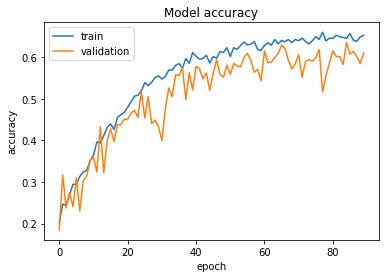

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

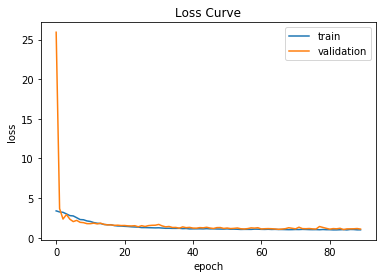

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()